In [1]:
#Using YOLO world for Open Vocabulary Detection
from ultralytics import YOLOWorld

# Initialize a YOLO-World model
model = YOLOWorld("yolov8s-world.pt")  # or select yolov8m/l-world.pt for different sizes

# Define desired objects/classes
desired_object= "red candle"
model.set_classes([desired_object])

# Define img path and predict/show result
img_path="Test_images/table.JPG"
results = model.predict(img_path)
results[0].show()


image 1/1 /Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/Test_images/table.JPG: 640x480 1 red candle, 55.3ms
Speed: 1.5ms preprocess, 55.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)


In [2]:
#Object Tracking YOLO World
from ultralytics import YOLOWorld

model.set_classes(["wine bottle"])

results = model.track(source="Test_images/video_wine_bottle.mp4", show=True, tracker="bytetrack.yaml",save=True)

for result in results:
    if result.boxes.id is not None:
        ids = result.boxes.id.int().cpu().tolist()
        print(f"Tracking IDs in this frame: {ids}")


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/210) /Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/Test_images/video_wine_bottle.mp4: 640x384 1 wine bottle, 47.6ms
video 1/1 (frame 2/210) /Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/Test_images/video_wine_bottle.mp4: 640x384 1 wine bottle, 51.1ms
video 1/1 (frame 3/210) /Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/Test_images/video_wine_bottle.mp4: 640x384 1 w

In [3]:
#Using Grounding Dino
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from accelerate import Accelerator
model_id = "IDEA-Research/grounding-dino-tiny"
device = Accelerator().device

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_path = "Test_images/table.JPG"
image = Image.open(image_path)
# Check for cats and remote controls
text_labels = [["a remote control", "red candle", "wine bottle","a pair of wool socks", "notebook"]]

inputs = processor(images=image, text=text_labels, return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    threshold=0.3,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)

result = results[0]
for box, score, labels in zip(result["boxes"], result["scores"], result["labels"]):
    box = [round(x, 2) for x in box.tolist()]
    print(f"Detected {labels} with confidence {round(score.item(), 3)} at location {box}")

/Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/.cvenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/.cvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Detected a pair with confidence 0.942 at location [2975.76, 1893.24, 4511.21, 3735.99]
Detected notebook with confidence 0.799 at location [266.19, 367.63, 1261.71, 1809.05]
Detected a remote control with confidence 0.69 at location [1618.29, 220.04, 2174.7, 942.51]
Detected wine bottle with confidence 0.782 at location [593.25, 933.22, 2741.43, 1605.44]
Detected red candle with confidence 0.335 at location [1586.35, 2549.73, 2972.65, 3202.11]
Detected red candle with confidence 0.348 at location [1448.3, 3540.36, 2053.06, 3834.1]


/Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/.cvenv/lib/python3.9/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


/Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/.cvenv/lib/python3.9/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


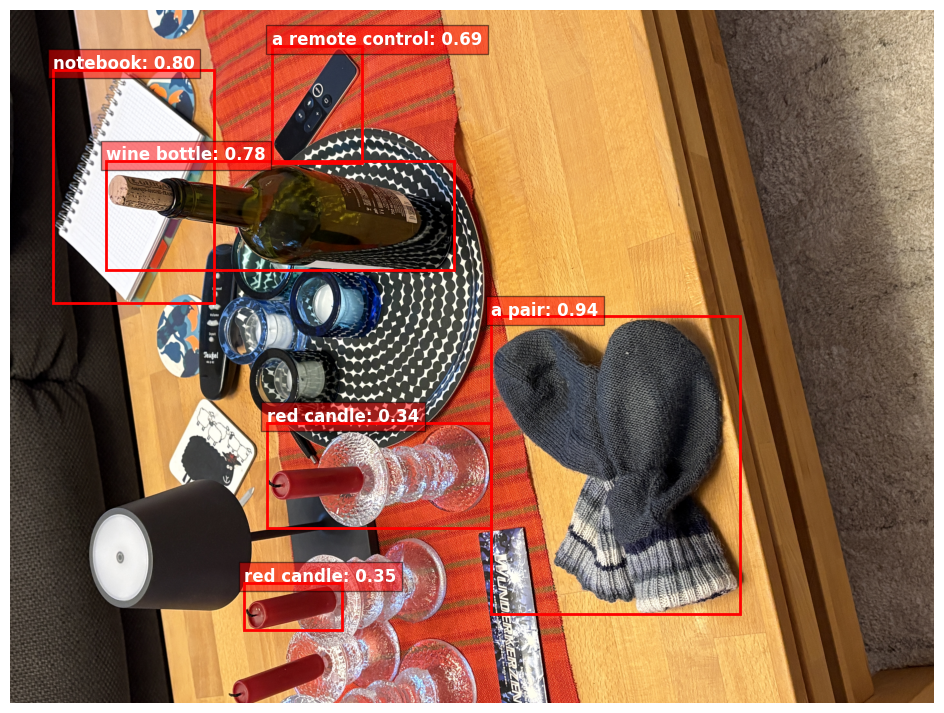

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)
for box, score, label in zip(result["boxes"], result["scores"], result["labels"]):
    xmin, ymin, xmax, ymax = box.tolist()

    rect = patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin, 
        linewidth=2, edgecolor='r', facecolor='none'
    )

    ax.add_patch(rect)

    plt.text(xmin, ymin - 5, f"{label}: {score:.2f}", 
             color='white', fontsize=12, fontweight='bold',
             bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()